In [ ]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))

In [3]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Fibroblast/code"

In [4]:
coembed <- readRDS("../data/coembed/coembed.Rds")
coembed

An object of class Seurat 
221802 features across 52618 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

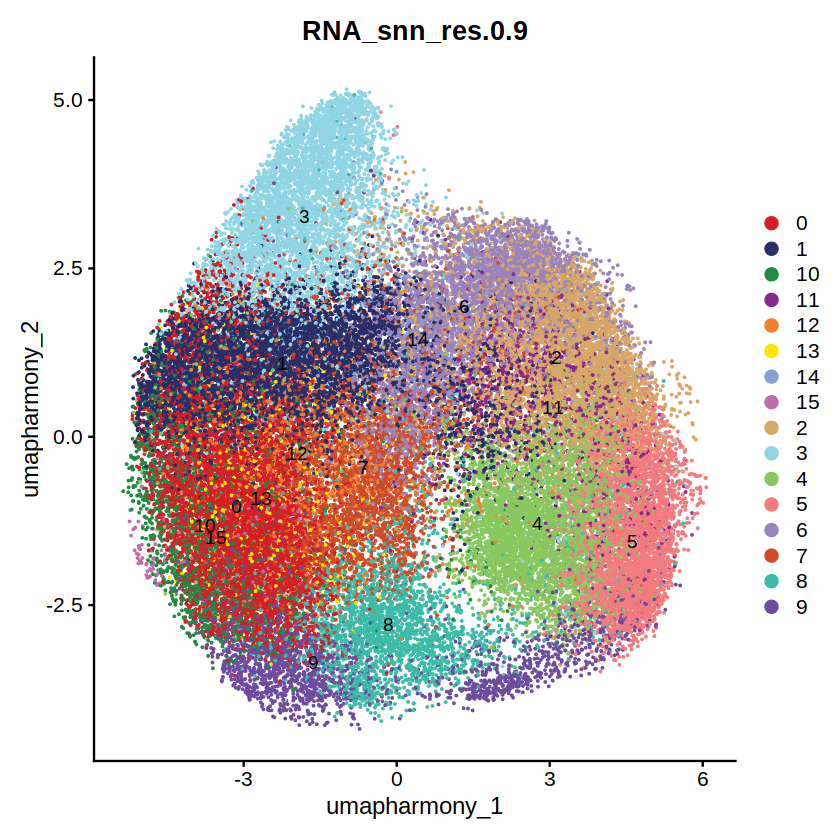

In [5]:
cols <- ArchR::paletteDiscrete(coembed@meta.data[, glue::glue("RNA_snn_res.0.9")])
DimPlot(coembed, reduction = "umap_harmony", group.by = "RNA_snn_res.0.9", cols = cols, label = TRUE)

In [6]:
## get number of cells per cluster and sample
df_count <- coembed@meta.data %>%
    as.data.frame() %>%
    subset(., tech == "RNA") %>%
    group_by(orig.ident, RNA_snn_res.0.9) %>%
    summarise(count = n()) %>%
    tidyr::pivot_wider(names_from = RNA_snn_res.0.9, values_from = count, values_fill = 0)

write.csv(df_count, "../data/coembed/stat_cell_counts_per_sample_rna.csv", row.names = FALSE)

`summarise()` has grouped output by 'orig.ident'. You can override using the `.groups` argument.



`summarise()` has grouped output by 'RNA_snn_res.0.9'. You can override using the `.groups` argument.



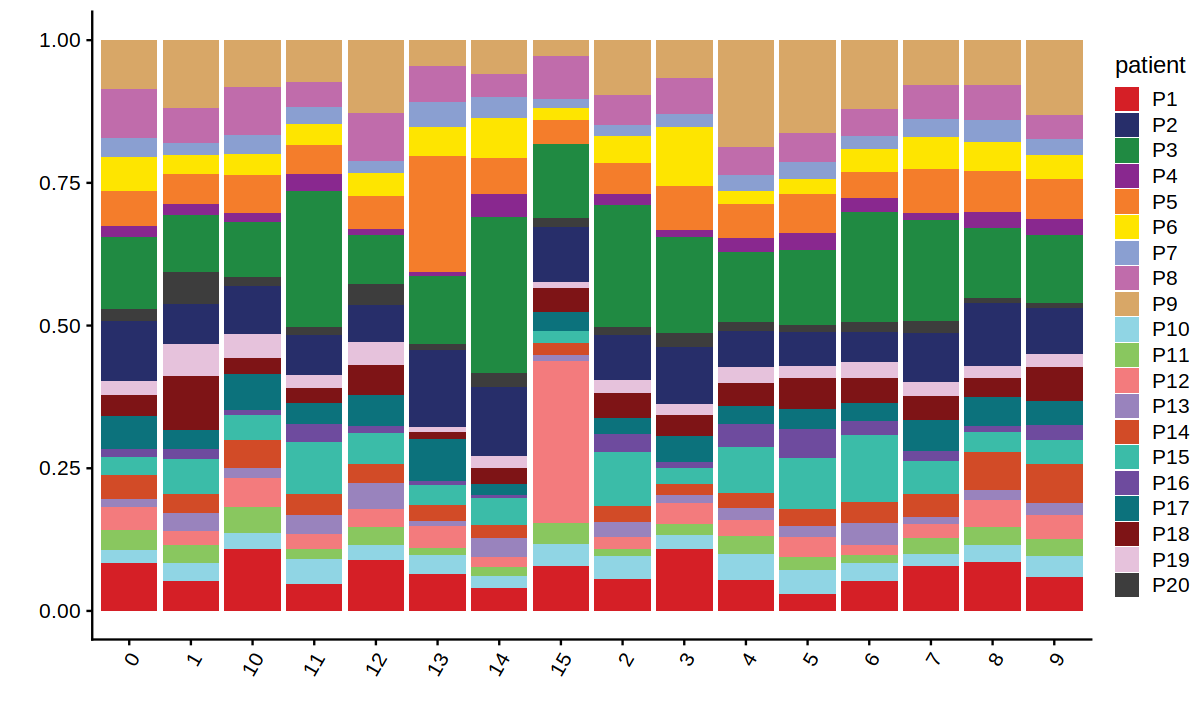

In [7]:
## check cell proportion across patients and modalities
meta.data <- as.data.frame(coembed@meta.data)

cols.patient <- ArchR::paletteDiscrete(meta.data$patient)

df_plot <-  meta.data %>%
    group_by(RNA_snn_res.0.9, patient) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(RNA_snn_res.0.9, cell_proportion, fill=patient)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
   scale_fill_manual(values = cols.patient) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'RNA_snn_res.0.9'. You can override using the `.groups` argument.



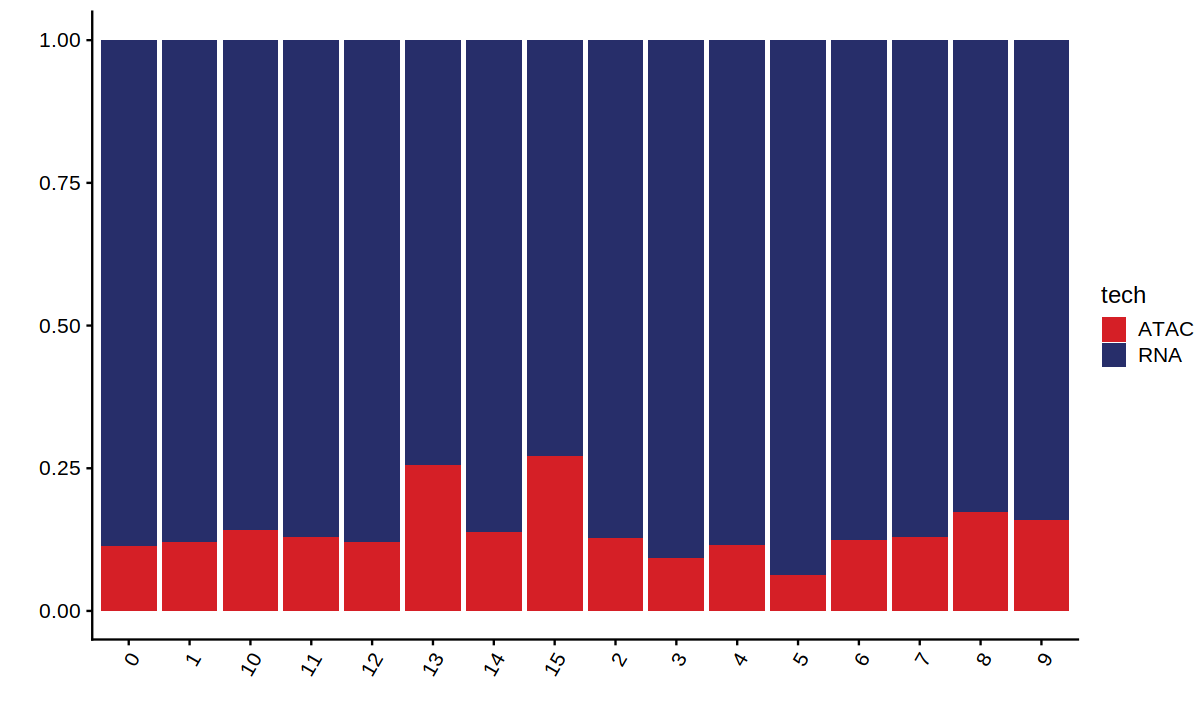

In [8]:
cols.tech <- ArchR::paletteDiscrete(meta.data$tech)

df_plot <-  meta.data %>%
    group_by(RNA_snn_res.0.9, tech) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(RNA_snn_res.0.9, cell_proportion, fill=tech)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
   scale_fill_manual(values = cols.tech) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

An object of class Seurat 
221802 features across 43563 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

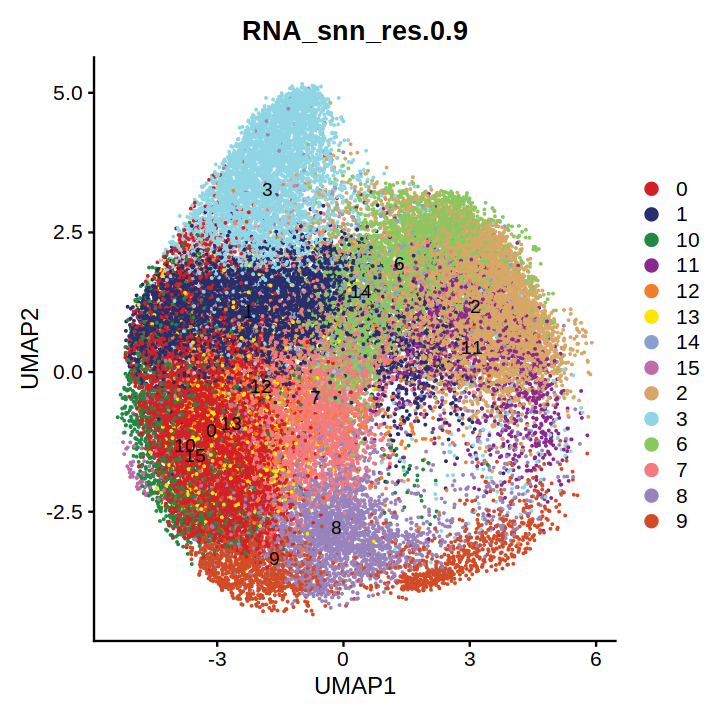

In [9]:
Idents(coembed) <- "RNA_snn_res.0.9"
coembed.sub <- subset(coembed, idents = c(4, 5), invert = TRUE)
coembed.sub

cols.clusters <- ArchR::paletteDiscrete(coembed.sub@meta.data[, "RNA_snn_res.0.9"])

options(repr.plot.height = 6, repr.plot.width = 6)

p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.0.9", label = TRUE,
             reduction = "umap_harmony", shuffle = TRUE, cols = cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [10]:
coembed.sub <- RunUMAP(coembed.sub, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony_v2",
               reduction.ke = 'umap_harmony_v2_',
              verbose = FALSE,
                   min.dist = 0.4)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_harmony_v2_ to umapharmonyv2_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to umapharmonyv2_”


In [12]:
## re-clustering
resolutions <- seq(0.1, 1, 0.1)

coembed.sub <- FindNeighbors(coembed.sub, reduction = "harmony", dims = 1:30)
coembed.sub <- FindClusters(coembed.sub, resolution = resolutions, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



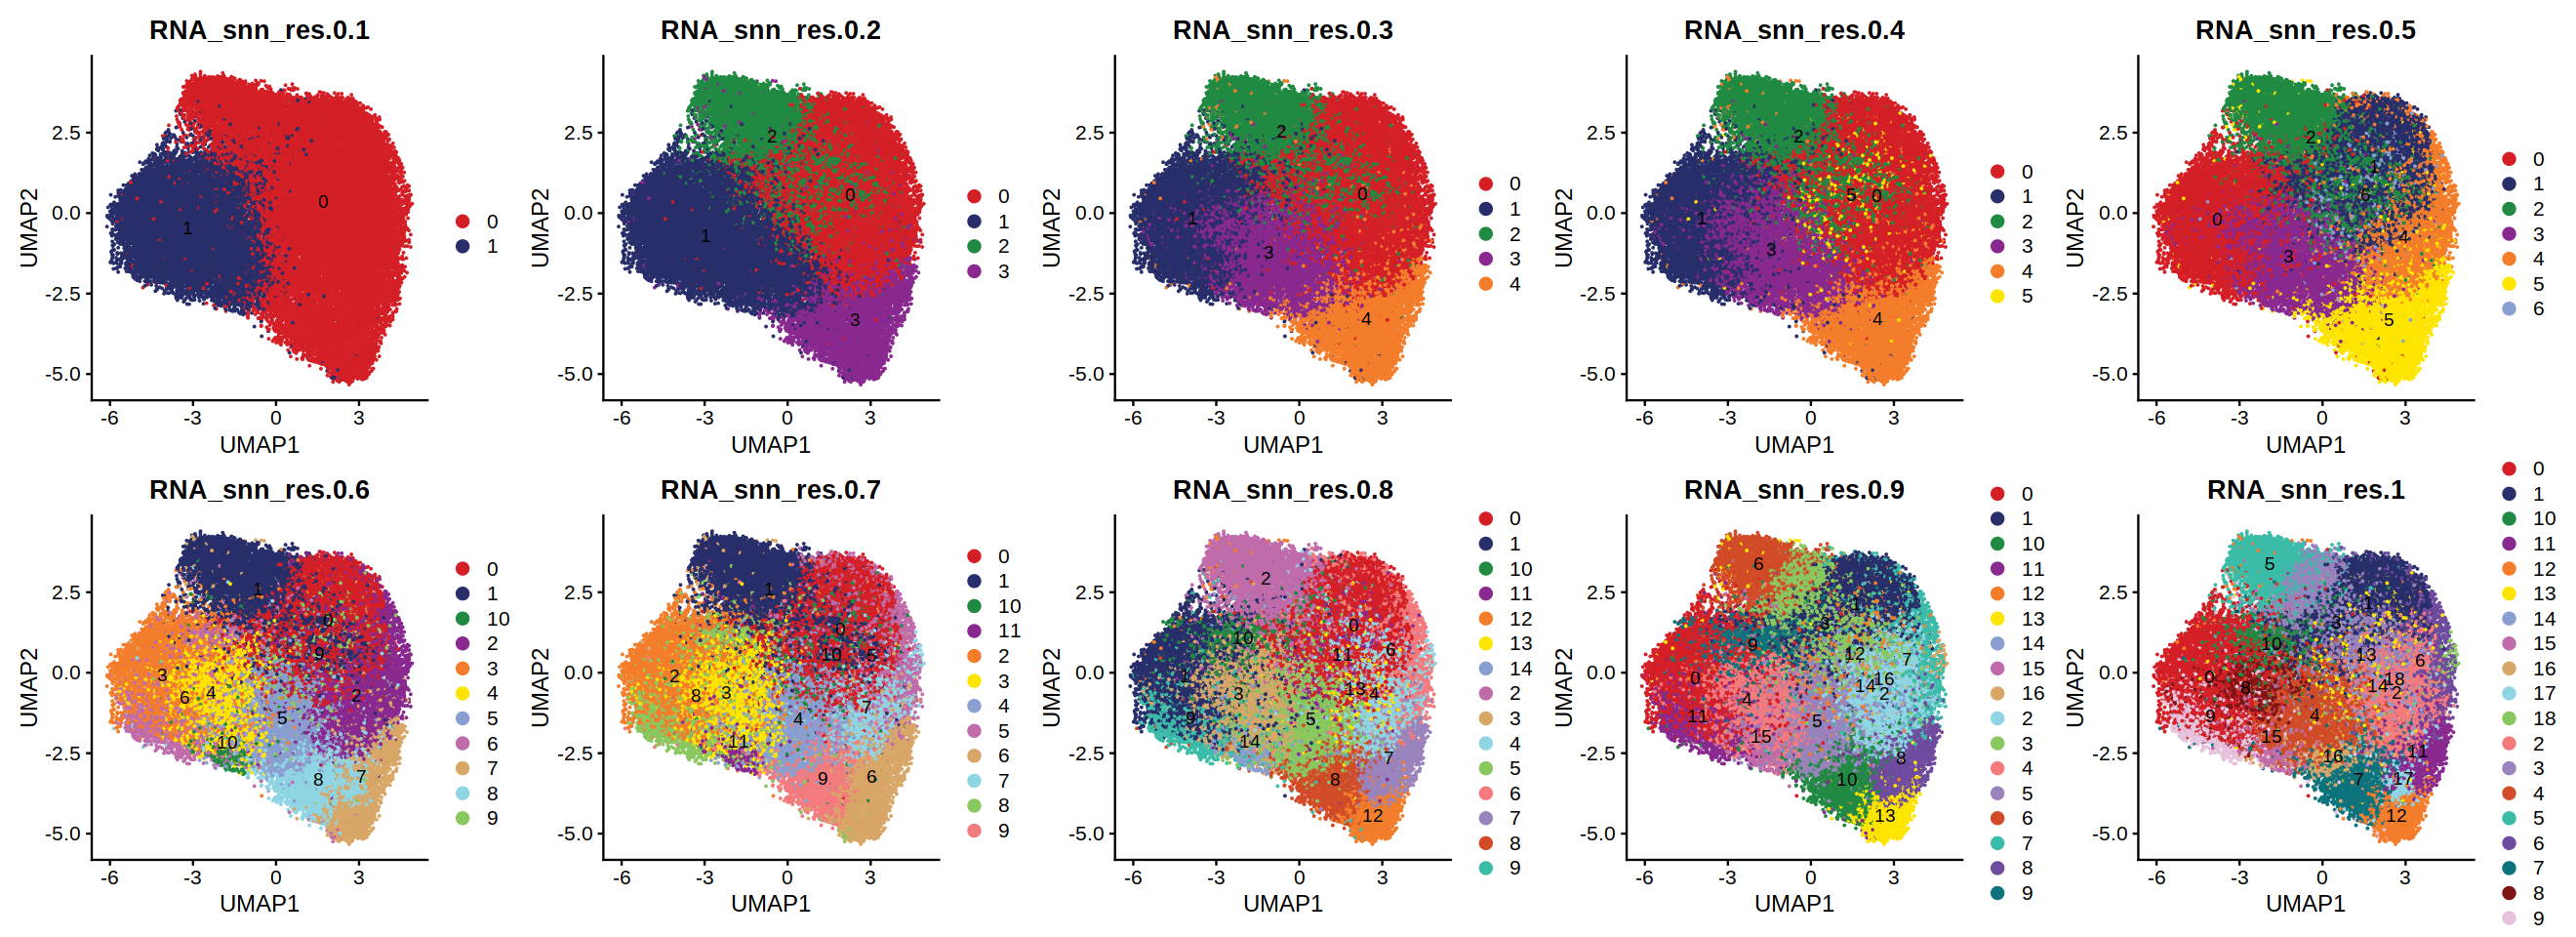

In [15]:
options(repr.plot.height = 8, repr.plot.width = 22)

plotlist <- lapply(resolutions, function(x){
    cols <- ArchR::paletteDiscrete(coembed.sub@meta.data[, glue::glue("RNA_snn_res.{x}")])
    
    p <- DimPlot(coembed.sub, group.by = glue::glue("RNA_snn_res.{x}"), label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE) +
    scale_color_manual(values = cols) +
    xlab("UMAP1") + ylab("UMAP2")
    
    p
})

p <- patchwork::wrap_plots(plotlist, nrow = 2)

p

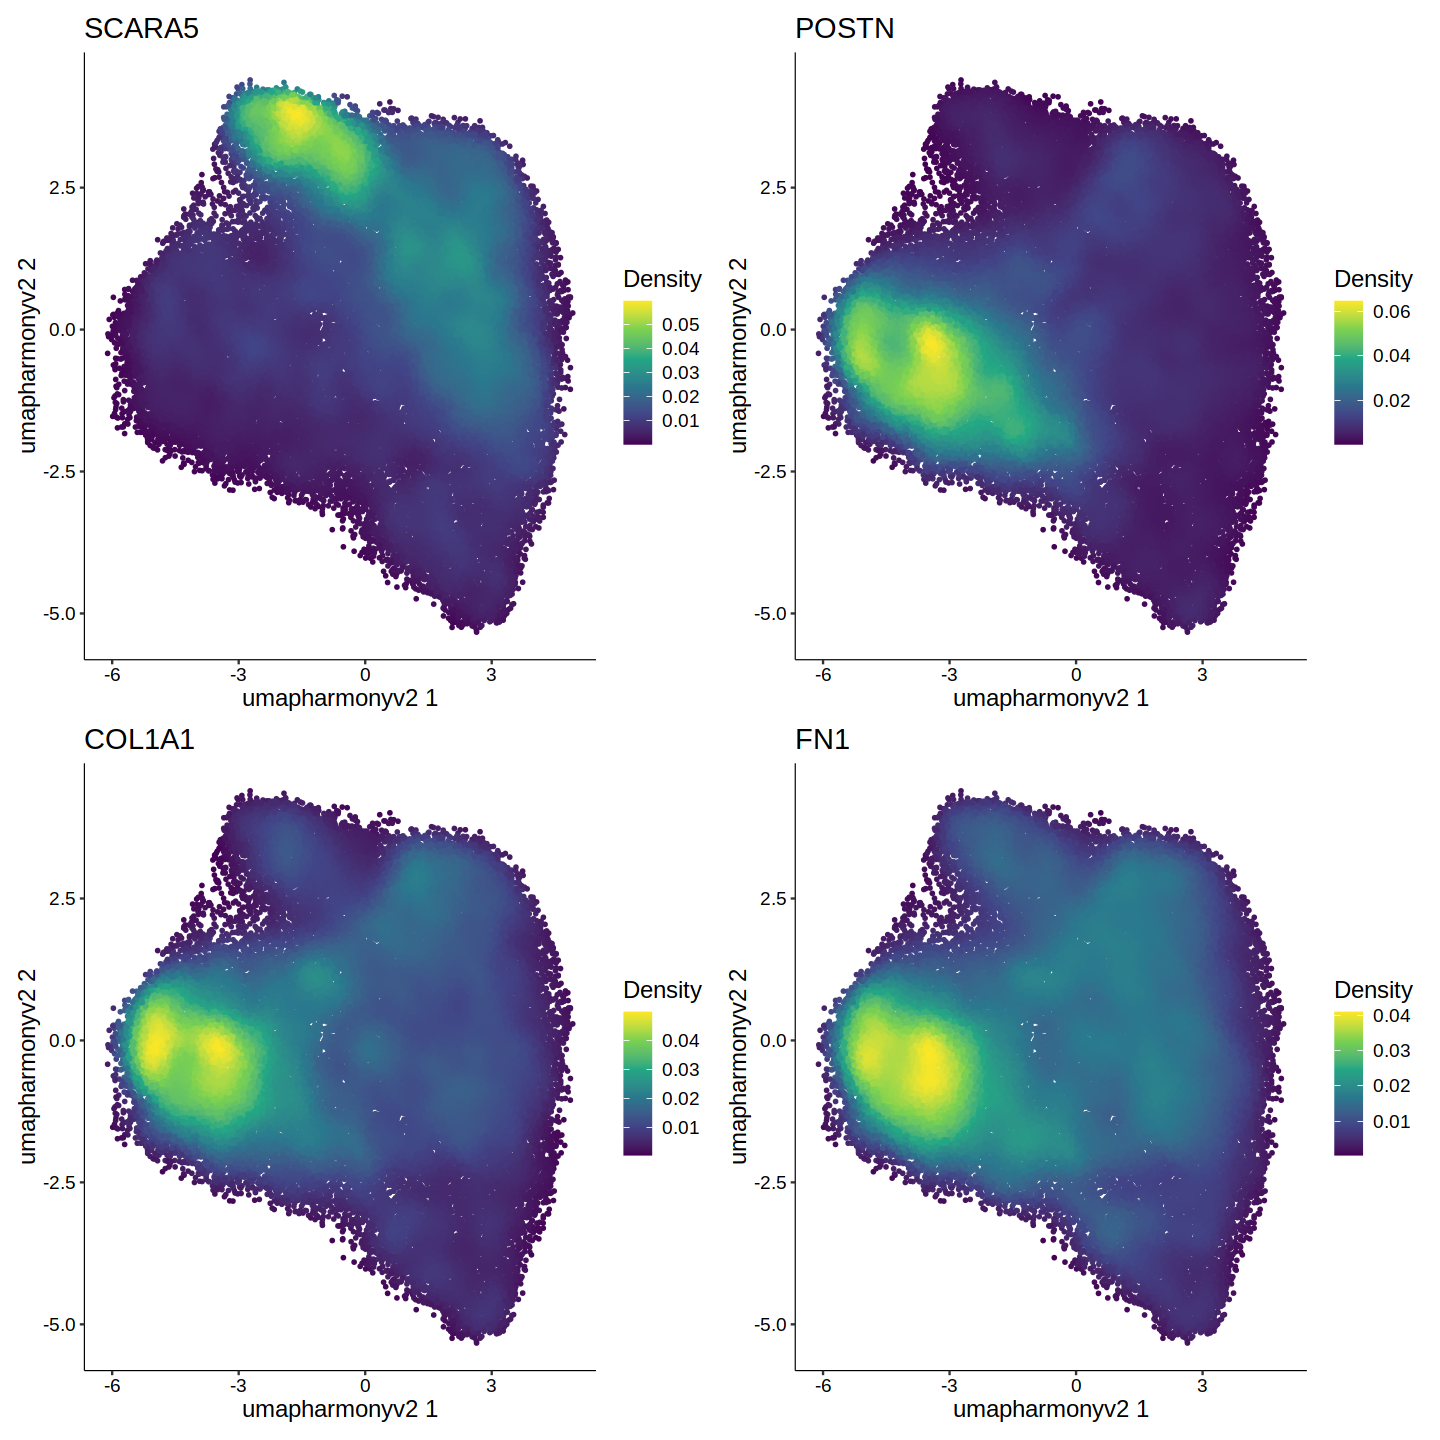

In [16]:
options(repr.plot.height = 12, repr.plot.width = 12)

p1 <- plot_density(coembed.sub, features="SCARA5", reduction="umap_harmony_v2")
p2 <- plot_density(coembed.sub, features="POSTN", reduction="umap_harmony_v2")
p3 <- plot_density(coembed.sub, features="COL1A1", reduction="umap_harmony_v2")
p4 <- plot_density(coembed.sub, features="FN1", reduction="umap_harmony_v2")

patchwork::wrap_plots(list(p1, p2, p3, p4), nrow = 2)

In [17]:
harmony_embedding <- coembed.sub@reductions$harmony@cell.embeddings

# run PHATE
phate_embedding <- phate(harmony_embedding, n.jobs = -1, npca = NULL,
                        knn.dist.method = "cosine")

colnames(phate_embedding$embedding) <- c("PHATE_1", "PHATE_2")

coembed.sub[['phate']] <- CreateDimReducObject(embeddings = phate_embedding$embedding)

harmony_1  harmony_2 harmony_3  harmony_4  harmony_5 
CK171#CGGACCAGTGAGTTGG-1  1.8781467 9.635162   0.6958936  2.2129353 -0.2275312
CK171#AAAGGGCAGGTAGGAA-1  0.3082793 3.694020   2.5466812 -0.9179014 -1.8022046
CK171#GTAGTACAGGCCTAAG-1 -0.7297526 6.439745   1.1843350  1.2297430 -0.7375783
CK171#GGGTCTGTCGGGTCCA-1 -2.2260936 6.551740   0.5540557  2.2669488 -0.8610584
CK171#TTCGATTGTGCAACAG-1 -5.7922024 3.377363  -0.1944910  0.0422499 -0.7000108
CK171#GTAGACTCATAGCCAT-1  0.3039103 3.996179   1.8875692 -0.9638840 -1.7792885
                         harmony_6  harmony_7  harmony_8     harmony_9 
CK171#CGGACCAGTGAGTTGG-1 -1.5839776 -0.4401533 -1.8725327431 -1.2202356
CK171#AAAGGGCAGGTAGGAA-1  0.1720373  0.0395247  0.4441763546 -1.2831143
CK171#GTAGTACAGGCCTAAG-1 -0.7606337  0.3096175 -0.7112560833 -1.9249474
CK171#GGGTCTGTCGGGTCCA-1 -0.2767862  1.2058314 -0.0781880861 -1.4348408
CK171#TTCGATTGTGCAACAG-1 -0.2247695 -1.2905923 -0.0006770847 -1.8871441
CK171#GTAGACTCATAGCCAT-1  0.3760317 -0.6830279  0.4143624798 -0.7727137
                         harmony_10 ⋯ harmony_41   harmony_42  harmony_43
CK171#CGGACCAGTGAGTTGG-1 -0.3080372 ⋯  0.371347565 -0.02210660 0.27149775
CK171#AAAGGGCAGGTAGGAA-1 -1.3848979 ⋯ -0.001379192 -0.33639576 0.01671375
CK171#GTAGTACAGGCCTAAG-1 -0.3813084 ⋯  0.355838208 -0.17419367 0.07022650
CK171#GGGTCTGTCGGGTCCA-1 -0.3855850 ⋯ -0.159991715 -0.04439163 0.09543777
CK171#TTCGATTGTGCAACAG-1 -0.7599909 ⋯ -0.273433585  0.11378161 0.17341310
CK171#GTAGACTCATAGCCAT-1 -1.0566042 ⋯ -0.094226281 -0.34865188 0.12261723
                         harmony_44  harmony_45  harmony_46   harmony_47 
CK171#CGGACCAGTGAGTTGG-1 -0.33916036 -0.09143387  0.127079369 -0.02766321
CK171#AAAGGGCAGGTAGGAA-1  0.04602345  0.07742847 -0.007932199  0.07224172
CK171#GTAGTACAGGCCTAAG-1 -0.02540225  0.21443688  0.049254373  0.03444778
CK171#GGGTCTGTCGGGTCCA-1 -0.03007234 -0.26002436  0.047238153 -0.14818957
CK171#TTCGATTGTGCAACAG-1  0.15634553  0.02663900  0.150802720  0.33038791
CK171#GTAGACTCATAGCCAT-1 -0.13566445  0.02264166  0.166334291 -0.05276900
                         harmony_48  harmony_49   harmony_50
CK171#CGGACCAGTGAGTTGG-1 -0.03845873 -0.174037406 0.48341324
CK171#AAAGGGCAGGTAGGAA-1  0.16792424 -0.081036137 0.31010589
CK171#GTAGTACAGGCCTAAG-1  0.11277759 -0.091253915 0.38275028
CK171#GGGTCTGTCGGGTCCA-1 -0.04782784  0.007303157 0.42008632
CK171#TTCGATTGTGCAACAG-1  0.40718301  0.084883965 0.02827101
CK171#GTAGACTCATAGCCAT-1  0.18708254  0.177563170 0.08002944

Warning message:
“No assay specified, setting assay as RNA by default.”


In [ ]:
options(repr.plot.height = 12, repr.plot.width = 12)

p1 <- plot_density(coembed.sub, features="SCARA5", reduction="phate")
p2 <- plot_density(coembed.sub, features="POSTN", reduction="phate")
p3 <- plot_density(coembed.sub, features="COL1A1", reduction="phate")
p4 <- plot_density(coembed.sub, features="FN1", reduction="phate")

patchwork::wrap_plots(list(p1, p2, p3, p4), nrow = 2)

ERROR: Error in FeaturePlot(coembed.sub, features = "SCARA5", reduction = "phate"): could not find function "FeaturePlot"


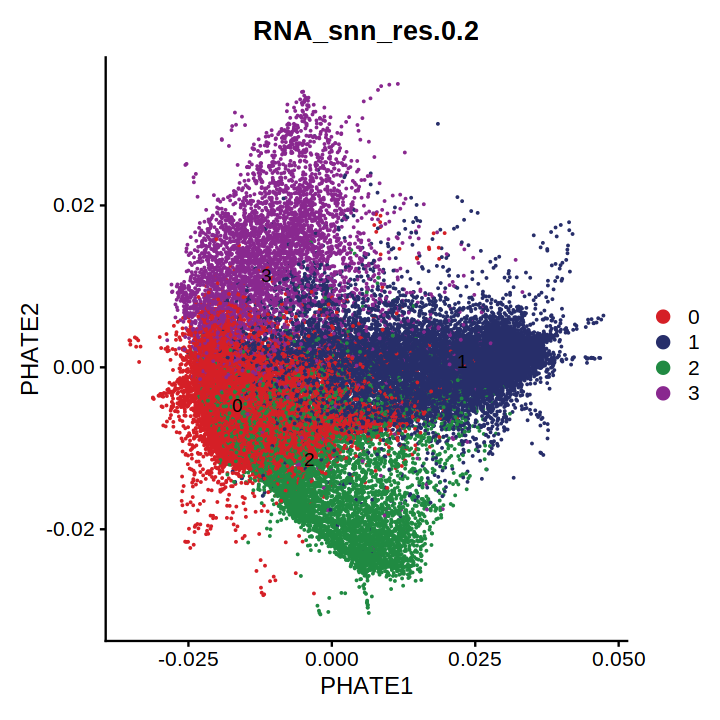

In [28]:
cols <- ArchR::paletteDiscrete(coembed.sub@meta.data[, glue::glue("RNA_snn_res.0.2")])

options(repr.plot.height = 6, repr.plot.width = 6)

DimPlot(coembed.sub, group.by = "RNA_snn_res.0.2", label = TRUE,
             reduction = "phate", shuffle = TRUE) +
    scale_color_manual(values = cols) +
    xlab("PHATE1") + ylab("PHATE2")

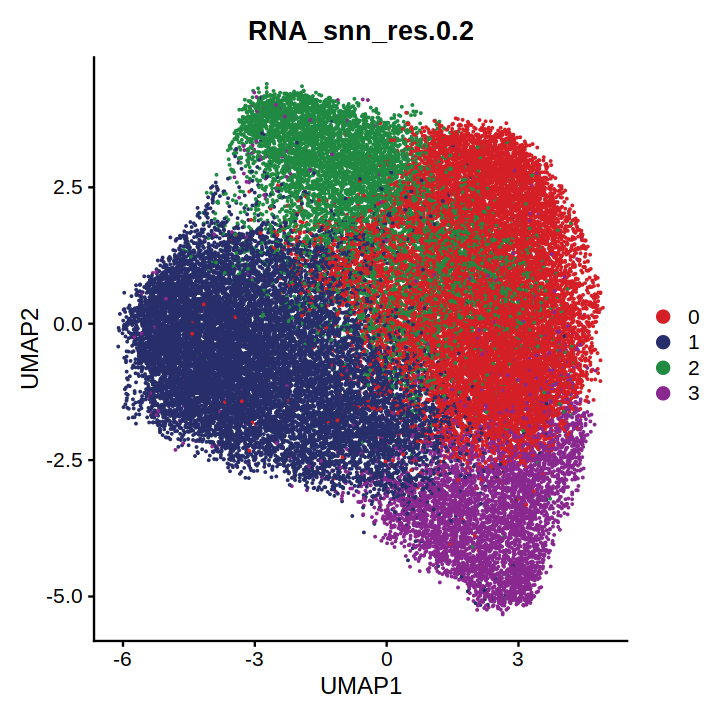

In [29]:
cols.clusters <- ArchR::paletteDiscrete(coembed.sub@meta.data[, "RNA_snn_res.0.2"])

p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.0.2", label = FALSE,
             reduction = "umap_harmony_v2", shuffle = TRUE) +
    scale_color_manual(values = cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

options(repr.plot.height = 6, repr.plot.width = 6)

p

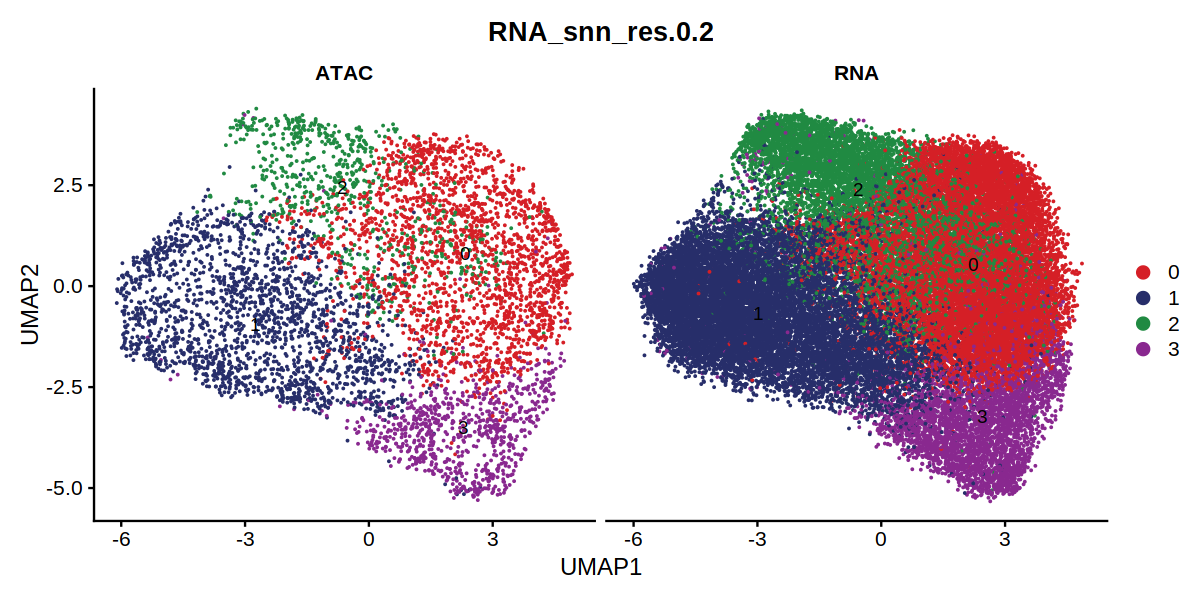

In [30]:
options(repr.plot.width = 10, repr.plot.height = 5)

p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.0.2", label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE, split.by = "tech", cols=cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [23]:
meta.data <- as.data.frame(coembed.sub@meta.data)

`summarise()` has grouped output by 'patient'. You can override using the `.groups` argument.



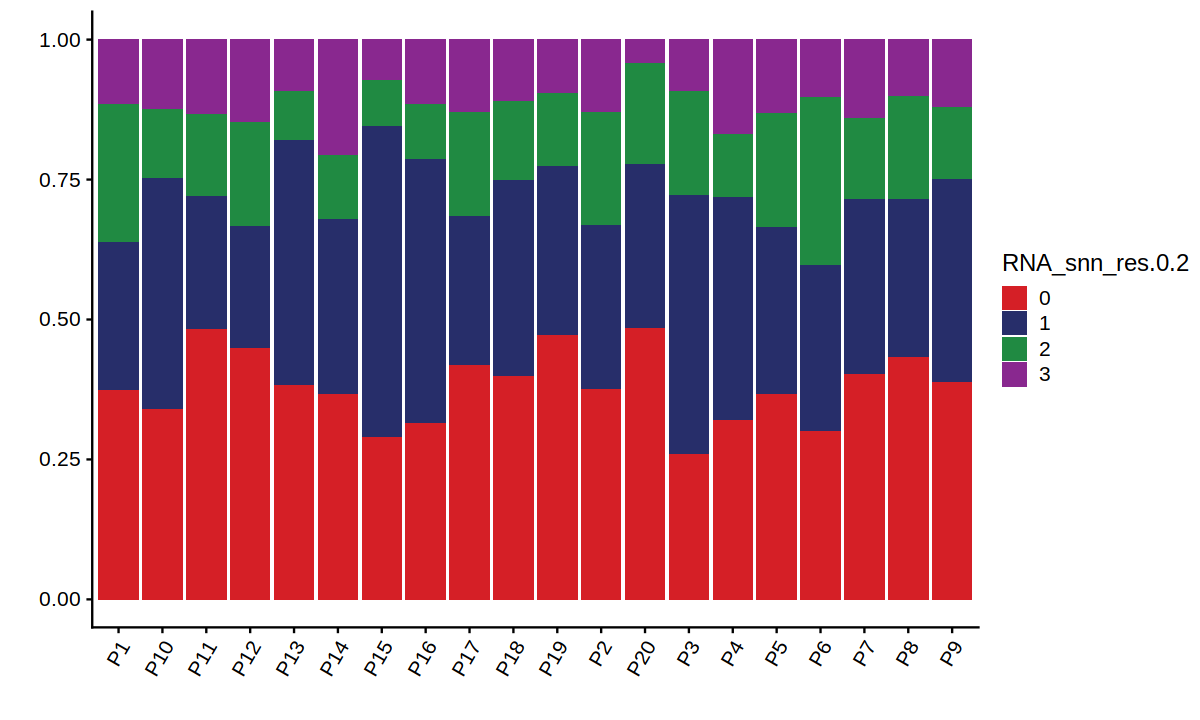

In [31]:
df_plot <-  meta.data %>%
    group_by(patient, RNA_snn_res.0.2) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient, cell_proportion, fill=RNA_snn_res.0.2)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.clusters) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.



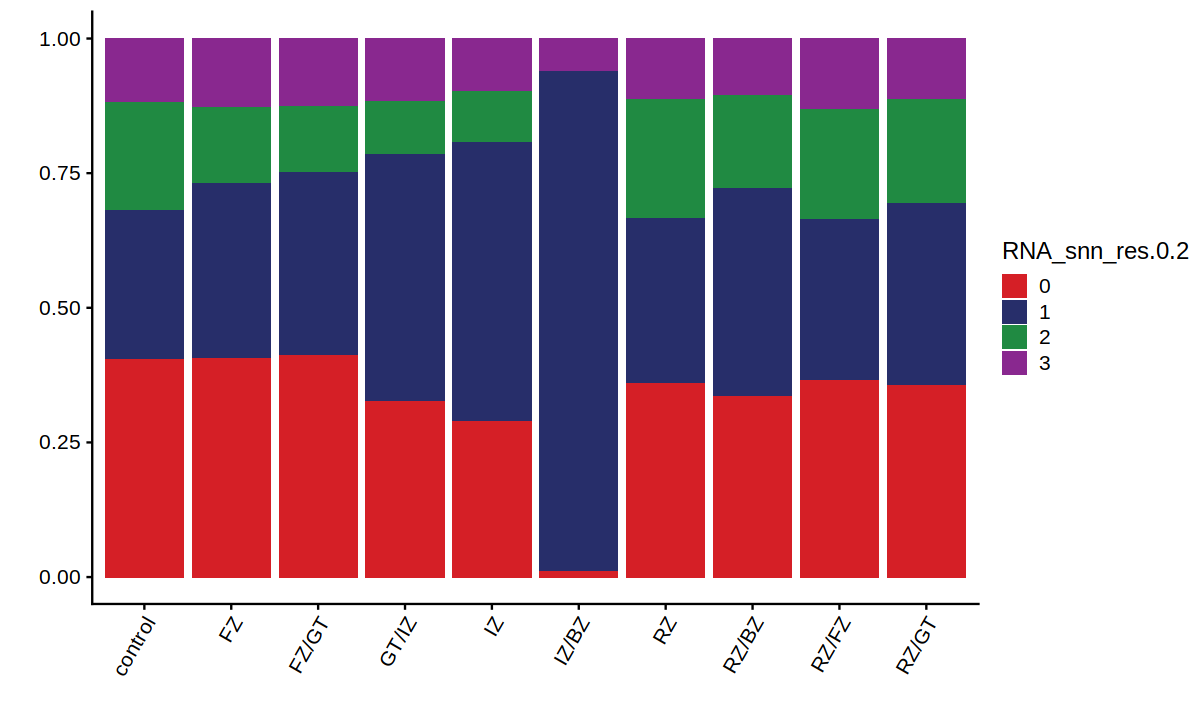

In [32]:
df_plot <- meta.data %>%
    group_by(region, RNA_snn_res.0.2) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(region, cell_proportion, fill=RNA_snn_res.0.2)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.clusters) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'patient_group'. You can override using the `.groups` argument.



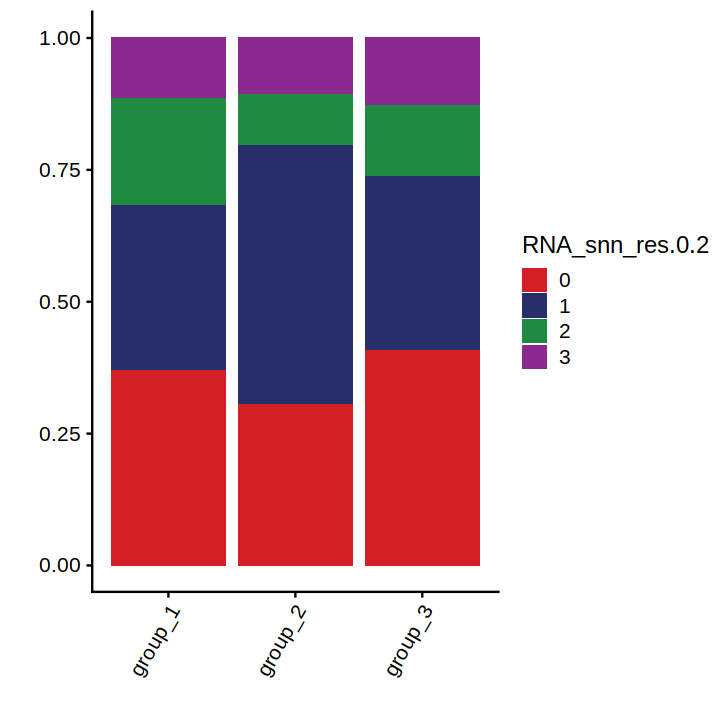

In [33]:
df_plot <- meta.data %>%
    group_by(patient_group, RNA_snn_res.0.2) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient_group, cell_proportion, fill=RNA_snn_res.0.2)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.clusters) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 6, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'patient_region_id'. You can override using the `.groups` argument.



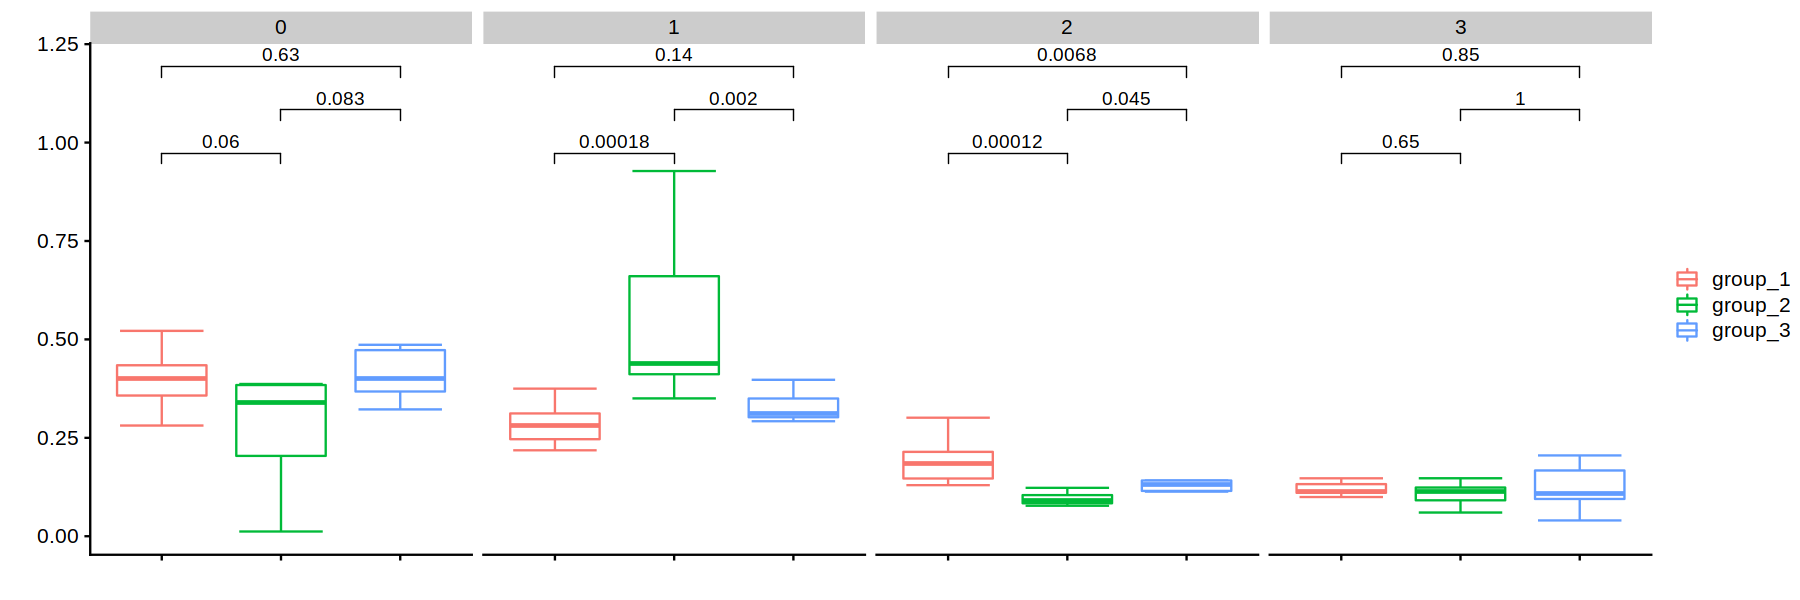

In [34]:
df_plot <- meta.data %>% 
            group_by(patient_region_id, RNA_snn_res.0.2) %>%
            summarise(counts = n()) %>%
            mutate(proportion = counts / sum(counts))

df_anno <- coembed@meta.data %>%
    as.data.frame() %>%
    subset(., select = c("patient_region_id", "patient_group")) %>%
    unique()

df_plot <- merge.data.frame(df_plot, df_anno)
    
    p <- ggplot(data = df_plot, aes(x = patient_group, y = proportion)) +
    geom_boxplot2(aes(color = patient_group)) +
    facet_wrap(~RNA_snn_res.0.2, nrow = 1) +
    stat_compare_means(comparisons = list(c("group_1", "group_2"),
                                         c("group_2", "group_3"),
                                         c("group_1", "group_3")),
                   method = "wilcox.test") +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_blank(),
         legend.title = element_blank())

options(repr.plot.width = 15, repr.plot.height = 5)

print(p)

In [ ]:
Idents(coembed.sub) <- "RNA_snn_res.0.2"

In [ ]:
all.markers <- FindAllMarkers(coembed.sub, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
    
df <- all.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

p <- DotPlot(coembed.sub, features = unique(df$gene)) + RotatedAxis()
    
options(repr.plot.height = 5, repr.plot.width = 15)

print(p)

In [ ]:
if(!dir.exists("../data/coembed/MarkerGenesAfterCleaning")){
    dir.create("../data/coembed/MarkerGenesAfterCleaning")
}

In [ ]:
markerList <- split(all.markers, all.markers$cluster)
    
    for(i in 1:length(markerList)){
        markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$avg_log2FC), ]
    }
    
    WriteXLS::WriteXLS(markerList,
                   ExcelFileName = glue::glue("../data/coembed/MarkerGenesAfterCleaning/res.0.2.xlsx"),
                   SheetNames = names(markerList))

saveRDS(all.markers, glue::glue("../data/coembed/MarkerGenesAfterCleaning/res.0.2.rds"))

In [ ]:
saveRDS(coembed.sub, file = "../data/coembed/coembed.cleaning.Rds")

In [ ]:
sessionInfo()